In [ ]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("large_models", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from parse_dataset import NetworkDataset, parse_dataset, split_datasets
from model import Model

In [4]:
conf = {
    "batch_size": 512,
    "epochs": 10,
    "learning_rate": 0.0001,
    "load_model": False
}


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd().replace("large_models", ""), "datasets", "network_packet_data_test.csv")

data, labels, label_dict = parse_dataset(network_data_file)

X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
X_train, X_val, X_test = X_train.unsqueeze(1), X_val.unsqueeze(1), X_test.unsqueeze(1)
print(X_train.shape)
print(y_train.shape)

# create train, val and test datasets
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 1, 513])
torch.Size([356334])


In [7]:
def check_class_balance(labels):
    n_labels = [0 for i in range(24)]
    for label in labels:
        n_labels[int(label)] += 1
    print(n_labels)

check_class_balance(y_train)

[125282, 38424, 14834, 7277, 35213, 54535, 1084, 9453, 13734, 3931, 17844, 2282, 10344, 2040, 7552, 7092, 1702, 555, 1296, 1022, 305, 355, 167, 11]


In [8]:
data, labels = next(iter(train_loader))
print(data.shape, labels.shape)

torch.Size([512, 1, 513]) torch.Size([512])


In [9]:
class OneDCNN(nn.Module):
    def __init__(self, input_size):
        super(OneDCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 32, 23),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, 19),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, 15),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 192, 11),
            nn.BatchNorm1d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv1d(192, 256, 7),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2)
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(1536, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2)
        )

        self.fc3 = nn.Linear(256, 24)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.fc3(x)

        return out

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.1, alpha=0.9, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
model = OneDCNN(X_train.shape[1]).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=conf["learning_rate"])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

onedcnn_model = Model(model, criterion, optimizer, scheduler, device)

if conf["load_model"]:
    checkpoint_path = os.path.join(os.getcwd().replace("large_models", ""), "checkpoint", "1dcnn_model.pth")
    onedcnn_model.load(checkpoint_path)

In [12]:
data, labels = next(iter(train_loader))
data, labels = data.to(device), labels.to(device)
pred = model(data)

In [13]:
def plot_data(data, type, title, n_epochs=conf["epochs"]):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    data = [d.to('cpu') for d in data]
    plt.plot(epochs, data, marker="+", linestyle="dotted")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(type)
    plt.show()

Epoch: 1/10, Accuracy: 0.58%, Train loss: 0.3641, Val loss: 17.1159
Epoch: 2/10, Accuracy: 2.91%, Train loss: 0.1545, Val loss: 21.3991
Epoch: 3/10, Accuracy: 2.92%, Train loss: 0.1177, Val loss: 27.3715
Epoch: 4/10, Accuracy: 2.91%, Train loss: 0.1050, Val loss: 34.0482
Epoch: 5/10, Accuracy: 2.92%, Train loss: 0.0829, Val loss: 31.1647
Epoch: 6/10, Accuracy: 2.91%, Train loss: 0.0710, Val loss: 45.6189
Epoch: 7/10, Accuracy: 2.91%, Train loss: 0.0607, Val loss: 46.9709
Epoch: 8/10, Accuracy: 3.87%, Train loss: 0.0598, Val loss: 27.9117
Epoch: 9/10, Accuracy: 3.86%, Train loss: 0.0574, Val loss: 43.3356
Epoch: 10/10, Accuracy: 2.90%, Train loss: 0.0461, Val loss: 42.3885


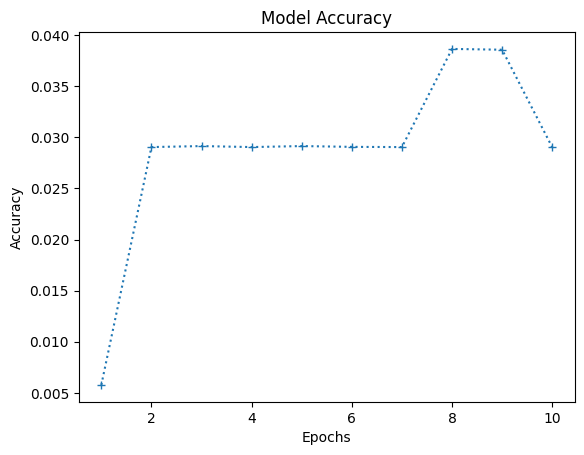

In [14]:
accuracy = []
train_loss = []
val_loss = []

if not conf["load_model"]:
    accuracy, train_loss, val_loss = onedcnn_model.train(train_loader=train_loader, val_loader=val_loader, epochs=conf["epochs"])
    plot_data(accuracy, type="Accuracy", title="Model Accuracy")